# NHL Playoff Bracket Predictions
### Uses regular season team summary statistics to predict playoff outcomes

In [8]:
import pandas as pd
import lstm

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Using TensorFlow backend.


In [9]:
# view tenslow enabled devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 881668429937917655
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 120179916
locality {
  bus_id: 1
}
incarnation: 3211447783419453893
physical_device_desc: "]


In [6]:
ls

 Volume in drive T is Data
 Volume Serial Number is E01F-4123

 Directory of T:\Dropbox\Projects\NHL

              11 File(s)        766,868 bytes
               4 Dir(s)  771,445,276,672 bytes free


# Read in the raw data from file

In [12]:
# regular season
reg = pd.read_csv('Data/2000_2017_regular_season.csv')
reg.head()

,year,Rk,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,GA,SOW,SOL,SRS,SOS,TG/G,EVGF,EVGA,PP,PPO,PP%,PPA,PPOA,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,PDO
0,2017,1,Washington Capitals*,28.4,82,55,19,8,118,0.720,263.0,182,2,5.0,0.99,0.00,5.43,199,130,57,248.0,22.98,44,272.0,83.82,5,3.0,9.0,8.5,2495.0,10.5,2282.0,0.922,102.5
1,2017,2,Pittsburgh Penguins*,28.7,82,50,21,11,111,0.677,282.0,234,4,5.0,0.59,0.01,6.29,213,170,60,260.0,23.08,52,257.0,79.77,5,7.0,8.4,8.7,2745.0,10.1,2671.0,0.914,101.0
2,2017,3,Chicago Blackhawks*,29.4,82,50,23,9,109,0.665,244.0,213,4,1.0,0.32,-0.06,5.57,197,158,42,233.0,18.03,47,211.0,77.73,1,7.0,6.9,7.8,2508.0,9.6,2574.0,0.918,101.3
3,2017,4,Columbus Blue Jackets*,26.2,82,50,24,8,108,0.659,249.0,195,2,2.0,0.68,0.02,5.41,195,152,42,211.0,19.91,39,223.0,82.51,10,2.0,8.6,8.5,2540.0,9.7,2489.0,0.922,101.2
4,2017,5,Minnesota Wild*,28.3,82,49,25,8,106,0.646,266.0,208,3,2.0,0.63,-0.08,5.78,211,166,47,224.0,20.98,37,217.0,82.95,5,3.0,8.0,8.3,2527.0,10.4,2465.0,0.916,101.5


In [13]:
# playoff stats
playoff = pd.read_csv('Data/2000_2017_playoffs.csv')
playoff.head()

,year,Rk,Team,GP,W,L,T,OW,OL,W-L%,G,GA,DIFF
0,2017,1,Pittsburgh Penguins,25,16,9,0,2,2,0.640,77,57,20
1,2017,2,Nashville Predators,22,14,8,0,2,1,0.636,60,48,12
2,2017,3,Ottawa Senators,19,11,8,0,6,2,0.579,47,50,-3
3,2017,4,Anaheim Ducks,17,10,7,0,4,1,0.588,50,52,-2
4,2017,5,Edmonton Oilers,13,7,6,0,1,3,0.538,36,35,1


# Cleanup
* playoff result is the outcome variable, so append playoff result to regular season dataframe
* will need a foreign key relationship of team/year between the two tables

In [15]:
def drop_pun(str_var):
    '''drop the list of chars from string'''
    ignore='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    str_cln=str_var.translate({ord(x): '' for x in ignore})
    return str_cln

In [19]:
reg.Team = reg.Team.apply(drop_pun)

In [25]:
# rename rank columns to more distinct
playoff.rename(columns={"Rk": "playoff_rank"}, inplace=True)
reg.rename(columns={"Rk": "reg_rank"}, inplace=True)

In [72]:
allData = pd.merge(reg, playoff[['year','Team','playoff_rank']], how = 'left', on = ['year', 'Team'])
allData.head()

,year,reg_rank,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,GA,SOW,SOL,SRS,SOS,TG/G,EVGF,EVGA,PP,PPO,PP%,PPA,PPOA,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,PDO,playoff_rank
0,2017,1,Washington Capitals,28.4,82,55,19,8,118,0.720,263.0,182,2,5.0,0.99,0.00,5.43,199,130,57,248.0,22.98,44,272.0,83.82,5,3.0,9.0,8.5,2495.0,10.5,2282.0,0.922,102.5,6.0
1,2017,2,Pittsburgh Penguins,28.7,82,50,21,11,111,0.677,282.0,234,4,5.0,0.59,0.01,6.29,213,170,60,260.0,23.08,52,257.0,79.77,5,7.0,8.4,8.7,2745.0,10.1,2671.0,0.914,101.0,1.0
2,2017,3,Chicago Blackhawks,29.4,82,50,23,9,109,0.665,244.0,213,4,1.0,0.32,-0.06,5.57,197,158,42,233.0,18.03,47,211.0,77.73,1,7.0,6.9,7.8,2508.0,9.6,2574.0,0.918,101.3,15.0
3,2017,4,Columbus Blue Jackets,26.2,82,50,24,8,108,0.659,249.0,195,2,2.0,0.68,0.02,5.41,195,152,42,211.0,19.91,39,223.0,82.51,10,2.0,8.6,8.5,2540.0,9.7,2489.0,0.922,101.2,13.0
4,2017,5,Minnesota Wild,28.3,82,49,25,8,106,0.646,266.0,208,3,2.0,0.63,-0.08,5.78,211,166,47,224.0,20.98,37,217.0,82.95,5,3.0,8.0,8.3,2527.0,10.4,2465.0,0.916,101.5,14.0


In [73]:
# drop teams that never made playoffs (playoff_rank will be NaN)
allData.playoff_rank.unique()

array([  6.,   1.,  15.,  13.,  14.,   4.,   9.,   5.,   8.,  nan,  11.,
         3.,  10.,  12.,   2.,  16.,   7.])

In [74]:
# drop rows that have nan values
allData.dropna(axis=0, inplace=True)

In [75]:
allData.playoff_rank.unique()

array([  6.,   1.,  15.,  13.,  14.,   4.,   9.,   5.,   8.,  11.,   3.,
        10.,  12.,   2.,  16.,   7.])

# Train/Test split
* train on < 2016 seasons
* test on 2017 season

In [76]:
x_train = allData[allData.year<2017].drop('playoff_rank', axis=1)
y_train = allData[allData.year<2017].playoff_rank

x_test = allData[allData.year==2017].drop('playoff_rank', axis=1)
y_test = allData[allData.year==2017].playoff_rank

In [77]:
x_train.shape

(138, 34)

In [78]:
x_train.head()

,year,reg_rank,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,GA,SOW,SOL,SRS,SOS,TG/G,EVGF,EVGA,PP,PPO,PP%,PPA,PPOA,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,PDO
30,2016,1,Washington Capitals,27.9,82,56,18,8,120,0.732,252.0,193,4,2.0,0.70,-0.02,5.43,191,148,55,251.0,21.91,38,256.0,85.16,2,5.0,9.0,8.7,2510.0,9.9,2332.0,0.918,101.1
31,2016,2,Dallas Stars,28.9,82,50,23,9,109,0.665,267.0,230,2,2.0,0.45,-0.01,6.06,197,169,58,262.0,22.14,44,248.0,82.26,10,15.0,8.5,8.7,2624.0,10.1,2371.0,0.904,99.8
33,2016,4,Pittsburgh Penguins,29.0,82,48,26,8,104,0.634,245.0,203,4,4.0,0.50,-0.01,5.46,182,154,48,261.0,18.39,40,257.0,84.44,11,5.0,8.4,8.8,2722.0,8.9,2436.0,0.918,100.5
34,2016,5,Anaheim Ducks,27.4,82,46,25,11,103,0.628,218.0,192,3,4.0,0.27,-0.05,5.00,152,148,56,245.0,22.86,37,290.0,87.24,7,3.0,12.3,10.9,2483.0,8.7,2258.0,0.917,99.2
35,2016,6,Florida Panthers,29.2,82,47,26,9,103,0.628,239.0,203,7,3.0,0.42,-0.02,5.39,180,140,47,278.0,16.91,55,268.0,79.48,5,5.0,10.1,10.0,2358.0,9.8,2419.0,0.917,101.7


In [79]:
x_train = x_train.drop(['year','Team'], axis=1).values.reshape(x_train.shape[0], 1, x_train.drop(['year','Team'], axis=1).shape[1])
x_test = x_test.drop(['year','Team'], axis=1).values.reshape(x_test.shape[0], 1, x_test.drop(['year','Team'], axis=1).shape[1])

In [80]:
x_train.shape, x_test.shape

((138, 1, 32), (15, 1, 32))

In [87]:
model = lstm.build_model(x_train, 
                         loss_function='mean_absolute_percentage_error',
                         timesteps=1, 
                         inlayer=int(x_train.shape[-1]*55),
                         hiddenlayers=[20,20], 
                         outlayer=1)

Compilation Time :  0.023061513900756836
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 1760)           12622720  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1760)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 20)             142480    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None,

In [88]:
history = model.fit(x_train, y_train, 
                    epochs=64, 
                    batch_size=16, 
                    validation_data=(x_test, y_test), 
                    verbose=2, 
                    shuffle=False)

Train on 138 samples, validate on 15 samples
Epoch 1/64
 - 4s - loss: 94.8204 - val_loss: 88.6922
Epoch 2/64
 - 0s - loss: 88.1085 - val_loss: 84.3022
Epoch 3/64
 - 0s - loss: 84.4917 - val_loss: 82.2015
Epoch 4/64
 - 0s - loss: 82.0770 - val_loss: 80.8802
Epoch 5/64
 - 0s - loss: 81.2957 - val_loss: 80.0624
Epoch 6/64
 - 0s - loss: 80.5814 - val_loss: 79.5520
Epoch 7/64
 - 0s - loss: 80.1384 - val_loss: 79.2338
Epoch 8/64
 - 0s - loss: 79.4667 - val_loss: 79.0359
Epoch 9/64
 - 0s - loss: 79.5309 - val_loss: 78.8991
Epoch 10/64
 - 0s - loss: 79.0833 - val_loss: 78.8050
Epoch 11/64
 - 0s - loss: 79.0776 - val_loss: 78.7359
Epoch 12/64
 - 0s - loss: 79.0795 - val_loss: 78.6793
Epoch 13/64
 - 0s - loss: 79.0245 - val_loss: 78.6338
Epoch 14/64
 - 0s - loss: 78.7972 - val_loss: 78.5979
Epoch 15/64
 - 0s - loss: 78.7688 - val_loss: 78.5729
Epoch 16/64
 - 0s - loss: 78.7300 - val_loss: 78.5529
Epoch 17/64
 - 0s - loss: 78.7739 - val_loss: 78.5353
Epoch 18/64
 - 0s - loss: 78.7322 - val_loss: 

In [89]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

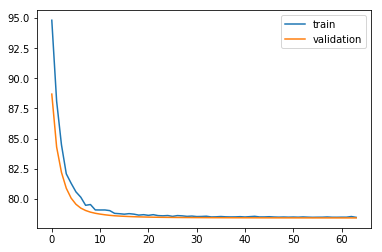

In [90]:
import matplotlib.pyplot as plt
plot_loss(history)